<a href="https://colab.research.google.com/github/CristylePGarrard/ElectionTime/blob/main/UT_candidates_ETL_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## First create dataframe for the current officials

In [1]:
# In this version I will add in additional column to show candidates who are already in office (inbumbent)
# and are running again for the same office. There are a number of candidates who are currently in one
# office but are running for another office. They will not be marked as incumbent because they are running
# for a different office than the one they currently hold.

# ####### Install necessary libraries ####### #
!pip install gspread gspread-dataframe pandas openpyxl

# ####### Import libraries ####### #
import pandas as pd
import gspread
from gspread_dataframe import get_as_dataframe
from google.colab import auth
from googleapiclient.discovery import build

# ####### Mount Google Drive to Colab ####### #
from google.colab import drive
drive.mount('/content/drive')

# ####### Authenticate
auth.authenticate_user()

from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)
drive_service = build('drive', 'v3', credentials=creds)

# Define the folder ID containing the Google Sheets
folder_url = 'https://drive.google.com/drive/u/0/folders/1PlbQb3HYSDSBDSSySW6CT9Oafjl5ksNI?ths=true'
folder_id = '1PlbQb3HYSDSBDSSySW6CT9Oafjl5ksNI'  # Replace with your folder ID

# Search for all Google Sheets in the folder
query = f"'{folder_id}' in parents and mimeType='application/vnd.google-apps.spreadsheet'"
results = drive_service.files().list(q=query, fields="files(id, name)").execute()
files = results.get('files', [])

# Get the URLs of each Google Sheet
sheet_urls = [f"https://docs.google.com/spreadsheets/d/{file['id']}" for file in files]

def read_google_sheet(sheet_url, worksheet_name=None):
    # Open the Google Sheet by its URL
    sheet = gc.open_by_url(sheet_url)
    # Select the worksheet
    if worksheet_name:
        worksheet = sheet.worksheet(worksheet_name)
    else:
        worksheet = sheet.get_worksheet(0)  # Default to the first sheet

    # Convert the worksheet to a DataFrame
    df = get_as_dataframe(worksheet, evaluate_formulas=True).dropna(how='all')  # Drop rows that are completely empty
    df['sheet_name'] = sheet.title  # Add a column with the sheet name
    return df

all_data = []

for url in sheet_urls:
    try:
        df = read_google_sheet(url)
        all_data.append(df)
    except Exception as e:
        print(f"Could not read {url}: {e}")

current_officials = pd.concat(all_data, ignore_index=True)

current_officials = current_officials.dropna(axis=1, how='all').copy().reset_index(drop=True)
# replace empty email with 'No Email'
current_officials['Email'].fillna('No Email', inplace=True)
# replace empty couties with No County
current_officials['County(ies)'].fillna('No County', inplace=True)
# replace null District with 0
current_officials['District'].fillna(0, inplace=True)
# format strings
current_officials['Name'] = current_officials['Name'].str.replace('  ', ' ').str.strip()
current_officials['Party'] = current_officials['Party'].str.strip().str.upper()
current_officials['Office'] = current_officials['Office'].str.strip()
current_officials['Email'] = current_officials['Email'].str.replace('  ', ' ').str.strip()
current_officials['County(ies)'] = current_officials['County(ies)'].str.replace('  ', ' ').str.strip()
# change District dtype to int
current_officials['District'] = current_officials['District'].astype(int)

def split_name(row):
  full_name = row['Name']
  name_parts = full_name.split(' ')

  if ',' in full_name:
    first_name = name_parts[1] if len(name_parts) > 0 else ''
    middle_name = name_parts[-1] if len(name_parts) == 3 else ''
    last_name = name_parts[0] if len(name_parts) > 1 else ''
  else:
    first_name = name_parts[0] if len(name_parts) > 0 else ''
    middle_name = name_parts[1] if len(name_parts) == 3 else ''
    last_name = name_parts[-1] if len(name_parts) > 1 else ''

  name_on_ballot = first_name + ' ' + middle_name + ' ' + last_name
  name_on_ballot = name_on_ballot.strip()
  row['First Name'] = first_name.strip()
  row['Middle Name'] = middle_name.strip()
  row['Last Name'] = last_name.strip()
  row['Name on Ballot'] = name_on_ballot

  return row

current_officials = current_officials.apply(split_name, axis=1)

def create_record_id(row):
    # Convert all parts to strings and handle NaN or None values by replacing them with an empty string
    first_name = str(row['First Name']) if not pd.isna(row['First Name']) else ''
    # middle_name = str(row['Middle Name']) if not pd.isna(row['Middle Name']) else ''
    # last_name = str(row['Last Name']) if not pd.isna(row['Last Name']) else ''
    office = str(row['Office']) if not pd.isna(row['Office']) else ''
    district = str(row['District']) if not pd.isna(row['District']) else ''

    # Create the record ID by concatenating all parts
    record_id = first_name + '-' + office + '-' + district

    # Add the record ID to the row
    row['record_id'] = record_id.strip().upper()

    return row

# Apply the function to each row in the DataFrame
current_officials = current_officials.apply(create_record_id, axis=1)

# Optionally, save the combined DataFrame to a new file
file_path = '/content/drive/My Drive/ut_pol/'
save_filename = 'current_officials.csv'
current_officials.to_csv(file_path + save_filename, index=False)

Mounted at /content/drive


<ipython-input-1-6e2e7e53686d>:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  current_officials['Email'].fillna('No Email', inplace=True)
<ipython-input-1-6e2e7e53686d>:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

# Next create a dataframe with the candidate info

In [2]:
# ####### Mount Google Drive to Colab ####### #
from google.colab import drive
drive.mount('/content/drive')

# ####### Set the file path to uploaded Excel file ####### #
# Update the path with the actual location of file in Google Drive
file_path = '/content/drive/My Drive/ut_pol/'
filename = 'CandidateFiling24.xlsx'

# ####### Read the Excel file into a DataFrame ####### #
print("Reading Excel file...")

# There's a weird warning about the format and openpyxl but we don't gotta worry about that so ignore it
import warnings
warnings.simplefilter("ignore")

# Read the Excel file
candidates = pd.read_excel(file_path+filename, engine='openpyxl')

# ####### Clean the Data ####### #
print("Cleaning data...")

# ####### Handle missing values ####### #
# Display columns with missing values
missing_values = candidates.isnull().sum()
# print("Missing values per column:\n", missing_values)

# Fill missing emails with 'No Email' and websites with 'No Website'
candidates['Email'].fillna('No Email', inplace=True)
candidates['Website'].fillna('No Website', inplace=True)
# Fill missing 'District' values with 0
candidates['District'].fillna(0, inplace=True)

# ####### The rows with the judge info need to be parsed and separated into the other columns ####### #
import re

# Identify the judge info
# -- The format is different and phrased as a question about whether so and so
# -- should be retained as the judge in the 'Name on Ballot' column

judge_rows = candidates[candidates['Name on Ballot'].str.contains(r'\bShall\b', na=False)]

# function to extract and update the data, including middle names
def parse_question(row):
    question = row['Name on Ballot']

    # Extract the full name using regex between "Shall " and " be retained in "
    name_match = re.search(r'Shall\s([A-Z][A-Z\s\.]+)\sbe retained in', question)
    full_name = name_match.group(1).title() if name_match else 'Unknown Name'

    # Split the full name into parts (first, middle, last)
    name_parts = full_name.split()

    # Extract first, middle, and last names based on the number of name parts
    first_name = name_parts[0] if len(name_parts) > 0 else ''
    middle_name = name_parts[1] if len(name_parts) == 3 else ''
    last_name = name_parts[-1] if len(name_parts) > 1 else ''

    # Extract the office from the question
    office_match = re.search(r'office of (.+?)(?: of|$)', question, re.IGNORECASE)
    office = office_match.group(1).strip() if office_match else 'Unknown Office'

    # Extract the district from the question
    district_match = re.search(r'of the (.+?)(?:\?$)', question, re.IGNORECASE)
    district = district_match.group(1).strip() if district_match else 'Unknown District'

    # Update the row with the extracted information
    row['First Name'] = first_name
    row['Middle Name'] = middle_name
    row['Last Name'] = last_name
    row['Office'] = office
    row['District'] = district
    row['Name on Ballot'] = full_name  # Replace with the extracted full name

    return row

# Apply the function to the relevant rows
candidates.loc[judge_rows.index] = judge_rows.apply(parse_question, axis=1)

# ####### Standardize text data ####### #
# Strip leading/trailing whitespace, convert to title case
candidates['First Name'] = candidates['First Name'].str.strip().str.title()
candidates['Middle Name'] = candidates['Middle Name'].str.strip().str.title()
candidates['Last Name'] = candidates['Last Name'].str.strip().str.title()
# Convert to uppercase for consistency
candidates['Party'] = candidates['Party'].str.strip().str.upper()
# Strip leading/trailing whitespace
candidates['Office'] = candidates['Office'].str.strip()
candidates['Status'] = candidates['Status'].str.strip()
# Removing extra spaces from strings
candidates['Name on Ballot'] = candidates['Name on Ballot'].str.replace('  ', ' ').str.strip()
candidates['Website'] = candidates['Website'].str.replace('  ', ' ').str.strip()
candidates['Email'] = candidates['Email'].str.replace('  ', ' ').str.strip()

# ####### Remove duplicates ####### #
candidates.drop_duplicates(inplace=True)

# ####### Convert data types ####### #

# Separate numeric and judge district data
# Convert numeric district values to integers; keep judge districts as strings
def standardize_district(row):
    district = row['District']
    try:
        # Try converting to int, if possible
        district_num = int(district)
        row['District'] = district_num
        row['Display District'] = f"District {district_num}"  # For unified display purposes
    except ValueError:
        # Keep as string for judge districts
        row['Display District'] = district.strip()  # Use the existing string value for judges

    return row

# Apply the function to the DataFrame
candidates = candidates.apply(standardize_district, axis=1)

# create record id
candidates = candidates.apply(create_record_id, axis=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading Excel file...
Cleaning data...


# Now create a new column in the candidate dataframe to show candidates running again for the same office

In [3]:
# Create a set of all record_ids in combined_candidates for quick lookup
combined_record_ids = set(current_officials['record_id'])

# Add a column to candidates that checks if the record_id is in combined_record_ids
candidates['incumbent'] = candidates['record_id'].isin(combined_record_ids)

# Verify the changes
candidates.head()

# Optional: Save the cleaned data for future use
print("Saving cleaned_candidates_data to file...")
# candidates.to_csv('cleaned_candidates_data.csv', index=False)
save_filename = 'cleaned_candidates_data.csv'
candidates.to_csv(file_path+save_filename, index=False)

Saving cleaned_candidates_data to file...


# Optional: Save csv of only incumbent candidates

In [4]:
incumbents = candidates.loc[candidates['incumbent']].copy().reset_index(drop=True)
# print(incumbents.head())
print("Saving incumbents to file...")
save_filename = 'incumbents.csv'
incumbents.to_csv(file_path+save_filename, index=False)

Saving incumbents to file...


# Validate matching data

1. Check for Duplicate Keys: Ensure that the keys in each sheet are unique to prevent incorrect matches.

In [5]:
# Check for duplicates in the candidates running for office based on 'record_id' and 'Status'
running_duplicates = candidates[candidates.duplicated(subset=['record_id', 'Status'], keep=False)]

if not running_duplicates.empty:
    print("True duplicates found in candidates based on 'record_id' and 'Status':")
    print(running_duplicates)
else:
    print("No true duplicates in candidates based on 'record_id' and 'Status'")


# Check for duplicates in the current officials
current_duplicates = current_officials[current_officials['record_id'].duplicated()]
if not current_duplicates.empty:
    print("Duplicates found in current officials:", current_duplicates)
else:
    print("No duplicates in current officials")


No true duplicates in candidates based on 'record_id' and 'Status'
No duplicates in current officials


2. Check for Unmatched Keys in the Results Sheet: Ensure all keys in the results sheet exist in either the current or running candidates sheets.

In [6]:
# Find keys in results not in current officials
unmatched_in_current = set(incumbents['record_id']) - set(current_officials['record_id'])
print("Keys in results not found in current candidates:", unmatched_in_current)

# Find keys in results not in running candidates
unmatched_in_running = set(incumbents['record_id']) - set(candidates['record_id'])
print("Keys in results not found in running candidates:", unmatched_in_running)


Keys in results not found in current candidates: set()
Keys in results not found in running candidates: set()


3. Visual Validation:
Purpose: Visualize the distribution of records by office and district for each dataset to identify anomalies.

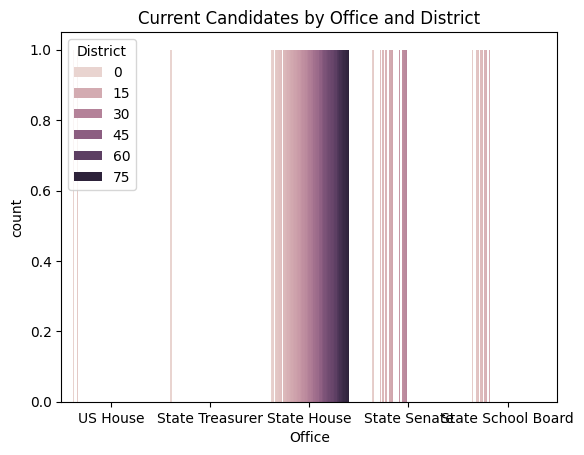

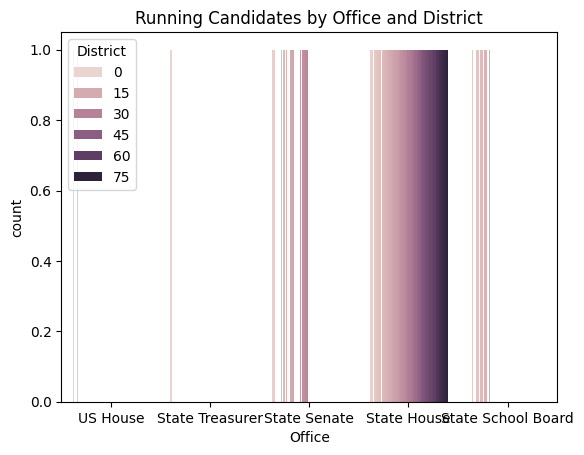

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

matching_records = incumbents['record_id']
filtered_offices = [x for x in candidates['Office'].unique() if x in current_officials['Office'].unique()]

curr = current_officials.loc[
    (current_officials['record_id'].isin(matching_records)) &
     (current_officials['Office'].isin(filtered_offices))
     ][[x for x in candidates.columns if x in current_officials.columns]]
cand = candidates.loc[
    (candidates['record_id'].isin(matching_records)) &
     (candidates['Office'].isin(filtered_offices))
     ][[x for x in candidates.columns if x in current_officials.columns]]

sns.countplot(data=curr, x='Office', hue='District')
plt.title('Current Candidates by Office and District')
plt.show()

sns.countplot(data=cand, x='Office', hue='District')
plt.title('Running Candidates by Office and District')
plt.show()
